# Programming for Data Science - Final Project : Invoice Data Analysis

## The Team

This project was done by Andrea Zanin, Clément Vurpillot and Antoine Ursel from DIA 6.

---

## 1. Introduction

Many phenomena can be modeled using computational systems. The modeling process begins by identifying the objects that comprise the overall system. Next, the attributes or characteristics of objects that simplify reality are described. These objects and their attributes are stored in data repositories such as databases, data warehouses, data lakes, and spreadsheets. Later, instances of these objects are created, populating the database. Data is essential for extracting information that improves our understanding of the phenomena under study and informs data-driven decision-making.

In this context, in this final project, the techniques learned in this course will be used to extract and visualize helpful information from different data sources.

---

## 2. Project Goal

The aim of this project is to implement a visualization prototype showing four indicators extracted from the available dataset. The **Knowledge Discovery in Databases (KDD)** process can be used to inspire the extraction of useful information from a real dataset.

Additionally, our proposed solution is **encapsulated**, dividing the main problem into small, independent tasks. This clarifies our code and enables reuse. Thus, each method or technique in our solution is implemented as a function using `def()` and includes any necessary parameters. We have reused and improved methods implemented in previous labs. Finally, all the functions created are called from a `main()` function implemented at the end of the project, which also launches the visualization prototype.

### Project Structure:
1. **Data Collection**: Load and store invoice data in a structure that allows data manipulation
2. **Data Exploration**: Explore the data using data summarization methods to fully understand it
3. **Indicator Extraction**: Extract four key indicators from the dataset using various techniques
4. **Visualization Prototype**: Create visualizations to present the findings
5. **Advanced Visualizations**: Implement additional visualizations for deeper insights

---

## 3. About the Dataset

The invoice dataset is a synthetic dataset created with the Python Faker library, designed to replicate the structure of data typically gathered from an online store. It includes multiple fields such as:

- **Customer details**: first name, last name, email
- **Transaction information**: product ID, quantity, amount, invoice date
- **Additional attributes**: address, city, stock code, job title

For more details, visit: https://www.kaggle.com/datasets/cankatsrc/invoices

---

## 4. Methodology

This project follows the **Knowledge Discovery in Databases (KDD)** methodology, which includes:

1. **Data Selection**: Loading the invoice dataset from CSV format
2. **Data Preprocessing**: Cleaning and transforming data for analysis
3. **Data Transformation**: Applying various techniques to extract meaningful patterns
4. **Data Mining**: Discovering patterns and relationships in the data
5. **Interpretation/Evaluation**: Visualizing and interpreting the results

All analysis steps are implemented as modular functions, ensuring code clarity, reusability, and maintainability.


---

# Step 1: Data Collection

## 1.1 Import Required Libraries

We'll use pandas for data manipulation, matplotlib and seaborn for visualization, and numpy for numerical operations. These libraries provide the necessary tools for loading, exploring, and visualizing the dataset.


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


## 1.2 Data Loading and Storage

### Function: load_invoice_data()

This function loads the CSV file and stores it in a pandas DataFrame, which provides excellent data manipulation capabilities. The DataFrame structure allows us to perform various operations such as filtering, grouping, aggregating, and transforming the data efficiently.


In [37]:
def load_invoice_data(file_path):
    """
    Load invoice data from CSV file into a pandas DataFrame.
    
    Parameters:
    -----------
    file_path : str
        Path to the CSV file containing invoice data
    
    Returns:
    --------
    pd.DataFrame
        DataFrame containing the invoice data
    """
    # Read CSV file into pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Convert invoice_date to datetime format for better manipulation
    df['invoice_date'] = pd.to_datetime(df['invoice_date'], format='%d/%m/%Y', errors='coerce')
    
    return df


## 1.3 Data Exploration

Data exploration is a crucial step in understanding our dataset. We need to examine the structure, content, and quality of the data before proceeding with analysis.

### Function: explore_dataset()

This function performs comprehensive data exploration including:
- **Number of rows and columns**: Understanding the dataset dimensions
- **Column names and data types**: Identifying all attributes and their types
- **Missing data analysis**: Detecting any missing values in each column
- **Basic statistical summaries**: Computing descriptive statistics for numerical and categorical variables
- **Variable correlations**: Calculating relationships between numerical variables (ranking between variables)


In [38]:
def explore_dataset(df):
    """
    Explore and summarize the dataset to understand its structure and content.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the invoice data
    
    Returns:
    --------
    dict
        Dictionary containing exploration results
    """
    exploration_results = {}
    
    # Basic dataset dimensions
    exploration_results['num_rows'] = len(df)
    exploration_results['num_columns'] = len(df.columns)
    exploration_results['column_names'] = df.columns.tolist()
    
    # Data types for each column
    exploration_results['data_types'] = df.dtypes.to_dict()
    
    # Missing data analysis
    missing_data = df.isnull().sum()
    missing_percentage = (missing_data / len(df)) * 100
    exploration_results['missing_data'] = pd.DataFrame({
        'Missing Count': missing_data,
        'Percentage': missing_percentage
    })
    
    # Basic statistics for numerical columns
    exploration_results['numerical_stats'] = df.describe()
    
    # Basic statistics for categorical columns
    exploration_results['categorical_stats'] = df.describe(include=['object'])
    
    return exploration_results


In [39]:
def display_exploration_results(exploration_results, df):
    """
    Display the exploration results in a formatted manner.
    
    Parameters:
    -----------
    exploration_results : dict
        Dictionary containing exploration results from explore_dataset()
    df : pd.DataFrame
        Original DataFrame for additional analysis
    """
    print("=" * 80)
    print("DATASET EXPLORATION SUMMARY")
    print("=" * 80)
    
    print(f"\n1. Dataset Dimensions:")
    print(f"   - Number of rows: {exploration_results['num_rows']:,}")
    print(f"   - Number of columns: {exploration_results['num_columns']}")
    
    print(f"\n2. Column Names:")
    for i, col in enumerate(exploration_results['column_names'], 1):
        print(f"   {i}. {col}")
    
    print(f"\n3. Data Types:")
    for col, dtype in exploration_results['data_types'].items():
        print(f"   - {col}: {dtype}")
    
    print(f"\n4. Missing Data Analysis:")
    missing_df = exploration_results['missing_data']
    missing_df = missing_df[missing_df['Missing Count'] > 0]
    if len(missing_df) > 0:
        print(missing_df.to_string())
    else:
        print("   No missing data found in the dataset!")
    
    print(f"\n5. Numerical Columns Summary:")
    print(exploration_results['numerical_stats'].to_string())
    
    print(f"\n6. Categorical Columns Summary:")
    print(exploration_results['categorical_stats'].to_string())
    
    print("\n" + "=" * 80)


## 1.4 Data Visualization for Understanding

Visual components are essential for understanding data distributions, patterns, and relationships. These visualizations help us identify outliers, understand variable distributions, and detect potential issues in the data.

We have split the data overview visualizations into three separate functions, each focusing on a specific aspect of the data:

### Function 1: visualize_invoice_amounts_distribution()

This function creates a histogram showing the frequency distribution of invoice amounts. This visualization helps us understand:
- The range of invoice values in the dataset
- The most common invoice amounts
- Whether the distribution is normal, skewed, or has multiple peaks
- Potential outliers or unusual patterns in the data

 


In [40]:
def visualize_invoice_amounts_distribution(df):
    """
    Visualize the distribution of invoice amounts using a histogram.
    
    This function creates a histogram that shows how invoice amounts are distributed
    across the dataset. It helps identify the most common invoice values, detect
    outliers, and understand the overall spending patterns.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the invoice data
    """
    plt.figure(figsize=(10, 6))
    plt.hist(df['amount'].dropna(), bins=50, edgecolor='black', alpha=0.7)
    plt.title('Distribution of Invoice Amounts', fontsize=14, fontweight='bold')
    plt.xlabel('Amount ($)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


### Function 2 : visualize_top_customers()

This function creates a horizontal bar chart showing the top customers ranked by their total lifetime value. This visualization helps us understand:
- Which customers generate the most revenue over time
- Customer loyalty and repeat purchase patterns
- The distribution of customer lifetime values
- Identification of VIP customers who may require special attention or loyalty programs
- Average invoice values for top customers


In [41]:
def visualize_top_customers(df, top_n=20):
    """
    Visualize top customers by total lifetime value, showing their spending patterns.
    Identifies repeat customers and ranks them by total spending.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the invoice data
    top_n : int, default=20
        Number of top customers to display
    """
    # Group by email to identify customers
    customer_analysis = df.groupby('email').agg({
        'amount': ['sum', 'mean', 'count'],
        'first_name': 'first',
        'last_name': 'first',
        'city': 'first'
    }).reset_index()
    
    # Flatten column names
    customer_analysis.columns = ['email', 'total_spending', 'avg_invoice_value', 
                                 'invoice_count', 'first_name', 'last_name', 'city']
    
    # Create customer name
    customer_analysis['customer_name'] = customer_analysis['first_name'] + ' ' + customer_analysis['last_name']
    
    # Sort by total spending
    customer_analysis = customer_analysis.sort_values('total_spending', ascending=False).head(top_n)
    
    # Create horizontal bar chart
    plt.figure(figsize=(14, 10))
    y_pos = np.arange(len(customer_analysis))
    
    bars = plt.barh(y_pos, customer_analysis['total_spending'].values, 
                     color='#8B4C89', alpha=0.8)
    
    # Add value labels
    for i, (idx, row) in enumerate(customer_analysis.iterrows()):
        plt.text(row['total_spending'] + max(customer_analysis['total_spending']) * 0.01,
                i, f"${row['total_spending']:,.0f} ({row['invoice_count']} invoices)",
                va='center', fontsize=9, fontweight='bold')
    
    # Truncate long names
    customer_labels = [name[:25] + '...' if len(name) > 25 else name 
                       for name in customer_analysis['customer_name'].values]
    
    plt.yticks(y_pos, customer_labels)
    plt.xlabel('Total Lifetime Value ($)', fontsize=12, fontweight='bold')
    plt.title(f'Top {top_n} Customers by Lifetime Value', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\n" + "=" * 80)
    print(f"TOP {top_n} CUSTOMERS ANALYSIS")
    print("=" * 80)
    for idx, row in customer_analysis.head(10).iterrows():
        print(f"\n{row['customer_name']} ({row['city']}):")
        print(f"  Total Lifetime Value: ${row['total_spending']:,.2f}")
        print(f"  Average Invoice Value: ${row['avg_invoice_value']:,.2f}")
        print(f"  Number of Purchases: {row['invoice_count']}")
    print("=" * 80 + "\n")


### Function 3: visualize_top_cities_by_invoice_count()

This function creates a horizontal bar chart showing the top 10 cities ranked by the number of invoices. This visualization helps us understand:
- Which cities generate the most business activity
- Geographic distribution of transactions
- Market concentration across different locations
- Potential areas for business expansion or marketing focus


In [42]:
def visualize_top_cities_by_invoice_count(df, top_n=10):
    """
    Visualize the top cities by invoice count using a horizontal bar chart.
    
    This function identifies and displays the cities with the highest number
    of invoices, providing insights into geographic business distribution and
    identifying key markets.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the invoice data
    top_n : int, default=10
        Number of top cities to display
    """
    plt.figure(figsize=(10, 6))
    top_cities = df['city'].value_counts().head(top_n)
    plt.barh(range(len(top_cities)), top_cities.values, color='green', alpha=0.7)
    plt.yticks(range(len(top_cities)), top_cities.index)
    plt.title(f'Top {top_n} Cities by Invoice Count', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Invoices')
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()


### Function 4: visualize_yearly_revenue_trends()

This function creates a line plot showing total invoice amounts aggregated by year. This visualization helps us understand:
- Revenue trends over time
- Growth or decline patterns in business performance
- Seasonal or annual patterns in revenue
- Long-term business trajectory and forecasting opportunities


In [43]:
def visualize_yearly_revenue_trends(df):
    """
    Visualize yearly revenue trends using a line plot.
    
    This function aggregates invoice amounts by year and displays them as a
    time series line plot. It helps identify revenue trends, growth patterns,
    and temporal changes in business performance.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the invoice data
    
    Note:
    -----
    This function requires valid date information in the 'invoice_date' column.
    If dates are not available, the function will not display a visualization.
    """
    if 'invoice_date' not in df.columns or df['invoice_date'].notna().sum() == 0:
        print("Date information not available for yearly revenue trend analysis.")
        return
    
    plt.figure(figsize=(12, 6))
    df_time = df.dropna(subset=['invoice_date']).copy()
    df_time['year'] = df_time['invoice_date'].dt.year
    yearly_amounts = df_time.groupby('year')['amount'].sum()
    
    plt.plot(yearly_amounts.index, yearly_amounts.values, marker='o', linewidth=2, markersize=8)
    plt.title('Total Invoice Amounts by Year', fontsize=14, fontweight='bold')
    plt.xlabel('Year')
    plt.ylabel('Total Amount ($)')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


---

# Step 2: Information Extraction Using Advanced Techniques

In this step, we apply different techniques to extract meaningful information from the dataset. This step includes:

1. **Grouping Queries** : Using SQL-like grouping operations to aggregate data
2. **Data Transformation Methods** : Normalization, discretization, and frequent pattern mining
3. **Temporal Analysis with Forecasting** : Time series analysis and revenue forecasting
4. **Spatial Analysis with Clustering** : Geographic clustering to identify market segments

## 2.1 Grouping Queries

Data transformation methods convert raw data into formats that are more suitable for analysis. We will apply three key transformation techniques:

1. **Normalization**: Scaling numerical values to a standard range (0-1) to compare variables with different scales
2. **Discretization**: Converting continuous variables into categorical bins for pattern analysis
3. **Frequent Pattern Mining**: Discovering frequently occurring patterns or associations in the data

### Function 1: calculate_total_revenue()

This function calculates **the total sum** of all invoice amounts.

**How it's calculated**: `df['amount'].sum()` - sums all values in the amount column across the entire DataFrame.

**What it represents**: The overall revenue generated from all invoices in the dataset.

**How to interpret**: Provides a quick view of total income. Higher totals indicate more revenue collected across all products or services, giving insight into the overall financial performance.

In [44]:
def calculate_total_revenue(df):
    """
    Calculate the total revenue from all invoices.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the invoice data
    
    Returns:
    --------
    float
        Total revenue amount
    """
    total_revenue = df['amount'].sum()
    return total_revenue


### Function 2: get_maximal_invoice_count_by_city()

This function calculates **the city with the highest number of invoices**. This grouping query aggregates revenue by product ID.

**How it's calculated**: `df.groupby('city')['invoice_date'].count()` - groups by city and counts the number of invoices for each city.
city_counts.max() – finds the maximum invoice count.
city_counts.idxmax() – finds the city corresponding to that maximum count.

**What it represents**: Shows which city has the most invoice activity, highlighting areas with higher business volume

**How to interpret**: Useful for understanding geographic distribution of sales. The city returned is where business activity is concentrated, and the count shows its scale relative to other cities.

In [45]:
def get_maximal_invoice_count_by_city(df):
    """
    Find the maximal number of invoices per city using grouping queries.
    
    This function demonstrates grouping queries by finding which city has
    the highest number of invoices.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the invoice data
    
    Returns:
    --------
    tuple
        (city_name, max_count) - City with maximum invoices and the count
    """
    # Group by city and count invoices
    city_counts = df.groupby('city')['invoice_date'].count()
    
    # Find the maximum count
    max_count = city_counts.max()
    city_with_max = city_counts.idxmax()
    
    return city_with_max, max_count


### Function 3: get_sum_of_amounts_by_product()

This function calculates **the sum of amounts** grouped by product. This grouping query aggregates revenue by product ID.

**How it's calculated**: `df.groupby('product_id')['amount'].sum()` - groups by product, sums amounts

**What it represents**: Total revenue generated by each product

**How to interpret**: Helps identify best-selling products and product performance. Products with higher sums contribute more to overall revenue.


In [46]:
def get_sum_of_amounts_by_product(df):
    """
    Calculate the sum of amounts grouped by product using grouping queries.
    
    This function demonstrates grouping queries by aggregating revenue by product.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the invoice data
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with product_id and total revenue (sum of amounts)
    """
    # Group by product_id and sum amounts
    product_sums = df.groupby('product_id')['amount'].sum().reset_index()
    product_sums.columns = ['product_id', 'total_revenue']
    
    # Sort by total revenue descending
    product_sums = product_sums.sort_values('total_revenue', ascending=False)
    
    return product_sums


## 2.2 Data Transformation Methods

Data transformation methods convert raw data into formats that are more suitable for analysis. We will apply three key transformation techniques:

1. **Normalization**: Scaling numerical values to a standard range (0-1) to compare variables with different scales
2. **Discretization**: Converting continuous variables into categorical bins for pattern analysis
3. **Frequent Pattern Mining**: Discovering frequently occurring patterns or associations in the data

### Technique 1: Normalization

Normalization transforms numerical values to a common scale, typically between 0 and 1, using min-max normalization. This allows us to compare variables that have different units or scales.

**Formula**: `normalized_value = (value - min) / (max - min)`

**What it represents**: Relative position of each value within the data range

**How to interpret**: Values closer to 1 are near the maximum, values closer to 0 are near the minimum. This helps identify outliers and understand relative performance.


In [47]:
def normalize_invoice_amounts(df):
    """
    Normalize invoice amounts using min-max normalization.
    
    This function transforms invoice amounts to a scale between 0 and 1,
    making it easier to compare invoices regardless of their absolute values.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the invoice data
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with original and normalized amounts
    """
    # Create a copy to avoid modifying original
    df_normalized = df.copy()
    
    # Calculate min and max values
    min_amount = df['amount'].min()
    max_amount = df['amount'].max()
    
    # Apply min-max normalization: (x - min) / (max - min)
    df_normalized['amount_normalized'] = (df['amount'] - min_amount) / (max_amount - min_amount)
    
    return df_normalized[['amount', 'amount_normalized']]


### Technique 2: Discretization

Discretization converts continuous numerical values into discrete categories or bins. This transformation helps identify patterns and simplifies analysis by grouping similar values together.

**Method**: Equal-width binning - divides the range into equal-sized intervals

**What it represents**: Categorical representation of continuous data

**How to interpret**: Each bin represents a range of values. This helps identify spending patterns, customer segments, and distribution characteristics.


In [48]:
def discretize_invoice_amounts(df, n_bins=5):
    """
    Discretize invoice amounts into bins using equal-width discretization.
    
    This function converts continuous invoice amounts into discrete categories,
    which helps identify spending patterns and customer segments.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the invoice data
    n_bins : int, default=5
        Number of bins to create
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with original amounts and discretized categories
    """
    # Create a copy to avoid modifying original
    df_discretized = df.copy()
    
    # Define bin labels
    bin_labels = [f'Low (${df["amount"].min():.2f}-${df["amount"].quantile(0.2):.2f})',
                  f'Medium-Low (${df["amount"].quantile(0.2):.2f}-${df["amount"].quantile(0.4):.2f})',
                  f'Medium (${df["amount"].quantile(0.4):.2f}-${df["amount"].quantile(0.6):.2f})',
                  f'Medium-High (${df["amount"].quantile(0.6):.2f}-${df["amount"].quantile(0.8):.2f})',
                  f'High (${df["amount"].quantile(0.8):.2f}-${df["amount"].max():.2f})']
    
    # Discretize using quantile-based binning
    df_discretized['amount_category'] = pd.qcut(df['amount'], 
                                                  q=n_bins, 
                                                  labels=bin_labels[:n_bins],
                                                  duplicates='drop')
    
    return df_discretized[['amount', 'amount_category']]


### Technique 3: Frequent Pattern Mining

Frequent pattern mining identifies patterns that occur frequently in the dataset. We'll use association rule mining to find frequently co-occurring product combinations.

**Method**: Market Basket Analysis - identifies which products are frequently purchased together

**What it represents**: Product associations and cross-selling opportunities

**How to interpret**: High support values indicate common patterns. This helps in product bundling, recommendations, and understanding customer purchase behavior.


In [49]:
def mine_frequent_product_patterns(df, min_support=0.01):
    """
    Mine frequent patterns of products purchased together.
    
    This function identifies frequently co-occurring products using
    market basket analysis principles. It groups products by invoice
    and finds patterns that occur above a minimum support threshold.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the invoice data
    min_support : float, default=0.01
        Minimum support threshold (fraction of transactions)
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with frequent product pairs and their support values
    """
    # Group products by invoice (transaction)
    transactions = df.groupby('invoice_date')['product_id'].apply(list).reset_index()
    
    # Find product pairs that appear together
    product_pairs = []
    pair_counts = {}
    total_transactions = len(transactions)
    
    for products in transactions['product_id']:
        # Get unique products in this transaction
        unique_products = list(set(products))
        # Generate pairs
        for i in range(len(unique_products)):
            for j in range(i+1, len(unique_products)):
                pair = tuple(sorted([unique_products[i], unique_products[j]]))
                pair_counts[pair] = pair_counts.get(pair, 0) + 1
    
    # Calculate support for each pair
    frequent_pairs = []
    for pair, count in pair_counts.items():
        support = count / total_transactions
        if support >= min_support:
            frequent_pairs.append({
                'product_1': pair[0],
                'product_2': pair[1],
                'support': support,
                'frequency': count
            })
    
    # Convert to DataFrame and sort by support
    if frequent_pairs:
        frequent_df = pd.DataFrame(frequent_pairs)
        frequent_df = frequent_df.sort_values('support', ascending=False)
        return frequent_df
    else:
        return pd.DataFrame(columns=['product_1', 'product_2', 'support', 'frequency'])


## 2.3 Temporal Analysis with Forecasting

Temporal analysis examines how data changes over time. We'll analyze revenue trends and apply forecasting techniques to predict future values.

### Function: analyze_temporal_revenue_trends()

This function performs time series analysis on revenue data, grouping by time periods (year/month) and identifying trends.

**How it's calculated**: Groups invoices by year and month, aggregates amounts, creates time series

**What it represents**: Revenue evolution over time, seasonal patterns, growth trends

**How to interpret**: Upward trends indicate growth, downward trends indicate decline. Seasonal patterns show cyclical behavior.


In [50]:
def analyze_temporal_revenue_trends(df):
    """
    Analyze temporal revenue trends by aggregating revenue over time periods.
    
    This function groups invoices by year and month to create a time series
    of revenue, enabling trend analysis and pattern identification.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the invoice data
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with time periods and aggregated revenue
    """
    if 'invoice_date' not in df.columns or df['invoice_date'].notna().sum() == 0:
        print("Date information not available for temporal analysis.")
        return None
    
    # Prepare temporal data
    df_time = df.dropna(subset=['invoice_date']).copy()
    df_time['year'] = df_time['invoice_date'].dt.year
    df_time['month'] = df_time['invoice_date'].dt.month
    
    # Group by year and month, aggregate revenue
    temporal_revenue = df_time.groupby(['year', 'month'])['amount'].sum().reset_index()
    temporal_revenue['date'] = pd.to_datetime(
        temporal_revenue[['year', 'month']].assign(day=1)
    )
    temporal_revenue = temporal_revenue.sort_values('date')
    temporal_revenue.columns = ['year', 'month', 'revenue', 'date']
    
    return temporal_revenue


### Function: forecast_revenue()

This function applies forecasting techniques to predict future revenue based on historical trends. We use a simple moving average forecast and linear trend projection.

**Method**: 
- Moving Average: Average of last N periods
- Linear Trend: Extrapolation using linear regression

**What it represents**: Predicted future revenue values based on historical patterns

**How to interpret**: Forecasts help in planning and budgeting. Compare forecasted values with actuals to assess prediction accuracy. Upward forecasts suggest growth, downward forecasts suggest decline.


In [51]:
def forecast_revenue(temporal_data, periods_ahead=6, method='moving_average'):
    """
    Forecast future revenue using time series forecasting techniques.
    
    This function applies forecasting methods to predict future revenue values
    based on historical trends. Supports moving average and linear trend methods.
    
    Parameters:
    -----------
    temporal_data : pd.DataFrame
        DataFrame with temporal revenue data (from analyze_temporal_revenue_trends)
    periods_ahead : int, default=6
        Number of future periods to forecast
    method : str, default='moving_average'
        Forecasting method: 'moving_average' or 'linear_trend'
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with historical and forecasted revenue values
    """
    if temporal_data is None or len(temporal_data) == 0:
        print("No temporal data available for forecasting.")
        return None
    
    revenue_values = temporal_data['revenue'].values
    dates = temporal_data['date']
    
    # Ensure dates is a pandas datetime Series
    if not isinstance(dates, pd.Series):
        dates = pd.Series(dates)
    dates = pd.to_datetime(dates)
    
    if method == 'moving_average':
        # Simple moving average forecast
        # Use average of last 3 periods as forecast
        window = min(3, len(revenue_values))
        last_avg = np.mean(revenue_values[-window:])
        forecasts = np.array([last_avg] * periods_ahead)
        
    elif method == 'linear_trend':
        # Linear trend forecast using linear regression
        x = np.arange(len(revenue_values))
        slope, intercept = np.polyfit(x, revenue_values, 1)
        
        # Forecast future values
        future_x = np.arange(len(revenue_values), len(revenue_values) + periods_ahead)
        forecasts = intercept + slope * future_x
    
    # Create forecast dates
    last_date = dates.iloc[-1]
    forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), 
                                    periods=periods_ahead, freq='MS')
    
    # Combine historical and forecasted data
    # Convert all to lists for DataFrame creation
    # Ensure forecasts is converted to list properly (handle numpy arrays)
    dates_list = dates.tolist()
    revenue_list = list(revenue_values) if not isinstance(revenue_values, list) else revenue_values
    forecasts_list = list(forecasts) if not isinstance(forecasts, list) else forecasts
    forecast_dates_list = forecast_dates.tolist()
    
    forecast_df = pd.DataFrame({
        'date': dates_list + forecast_dates_list,
        'revenue': revenue_list + forecasts_list,
        'type': ['historical'] * len(dates_list) + ['forecast'] * periods_ahead
    })
    
    return forecast_df


## 2.4 Spatial Analysis with Clustering 

Spatial analysis examines geographic patterns in the data. We'll apply clustering techniques to identify market segments based on geographic and revenue characteristics.

### Function: analyze_spatial_revenue_distribution()

This function aggregates revenue by geographic location (city) to understand spatial distribution of business.

**How it's calculated**: Groups invoices by city, aggregates revenue and counts

**What it represents**: Geographic distribution of business activity and revenue

**How to interpret**: Cities with higher revenue are key markets. This helps identify regional performance and market concentration.


In [52]:
def analyze_spatial_revenue_distribution(df):
    """
    Analyze spatial revenue distribution by aggregating revenue by city.
    
    This function groups invoices by city and calculates spatial metrics
    including total revenue, average invoice value, and transaction counts.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the invoice data
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with city-level revenue statistics
    """
    # Group by city and aggregate revenue metrics
    spatial_data = df.groupby('city').agg({
        'amount': ['sum', 'mean', 'count'],
        'email': 'nunique'  # Unique customers per city
    }).reset_index()
    
    # Flatten column names
    spatial_data.columns = ['city', 'total_revenue', 'avg_invoice_value', 
                           'invoice_count', 'unique_customers']
    
    # Calculate revenue per customer
    spatial_data['revenue_per_customer'] = spatial_data['total_revenue'] / spatial_data['unique_customers']
    
    # Sort by total revenue
    spatial_data = spatial_data.sort_values('total_revenue', ascending=False)
    
    return spatial_data


### Function: apply_spatial_clustering()

This function applies K-means clustering to identify market segments based on spatial revenue characteristics. Cities are clustered into groups with similar revenue patterns.

**Method**: K-means Clustering - partitions cities into k groups based on revenue features

**Features used**: Total revenue, average invoice value, invoice count, revenue per customer

**What it represents**: Market segments with similar characteristics

**How to interpret**: Cities in the same cluster have similar business patterns. This helps in:
- Targeted marketing strategies
- Resource allocation
- Market expansion planning
- Identifying underperforming or high-potential markets


In [53]:
def apply_spatial_clustering(spatial_data, n_clusters=3):
    """
    Apply K-means clustering to identify spatial market segments.
    
    This function clusters cities based on revenue characteristics using
    K-means algorithm to identify market segments with similar patterns.
    
    Parameters:
    -----------
    spatial_data : pd.DataFrame
        DataFrame with spatial revenue data (from analyze_spatial_revenue_distribution)
    n_clusters : int, default=3
        Number of clusters to create
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with cluster assignments for each city
    """
    # Select features for clustering
    features = ['total_revenue', 'avg_invoice_value', 'invoice_count', 'revenue_per_customer']
    X = spatial_data[features].values
    
    # Standardize features (important for K-means)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    
    # Add cluster assignments to data
    spatial_data_clustered = spatial_data.copy()
    spatial_data_clustered['cluster'] = clusters
    spatial_data_clustered['cluster'] = spatial_data_clustered['cluster'].astype(str)
    
    # Calculate cluster centers (in original scale)
    cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
    
    return spatial_data_clustered, cluster_centers, features


## 2.5 Visualization of Extracted Information

Each technique produces results that need to be visualized for better understanding and interpretation. We'll create visualizations for each method.


### Visualization: Grouping Queries Results


In [54]:
def visualize_grouping_queries_results(df):
    """
    Visualize results from grouping queries.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the invoice data
    """
    total_revenue = calculate_total_revenue(df)

    # Get maximal invoice count by city
    city_with_max, max_count = get_maximal_invoice_count_by_city(df)
    
    # Get sum of amounts by product
    product_sums = get_sum_of_amounts_by_product(df)
    
    # Visualization 1: Maximal invoice count by city
    print("\n" + "=" * 80)
    print("GROUPING QUERIES RESULTS")
    print("=" * 80)
    print(f"\nTotal Revenue:")
    print(f"  ${total_revenue:,.2f}")
    print(f"\nMaximal Number of Invoices by City:")
    print(f"  City: {city_with_max}")
    print(f"  Maximum Invoice Count: {max_count:,}")
    
    # Visualization 2: Sum of amounts by product (top 10)
    plt.figure(figsize=(12, 8))
    top_products = product_sums.head(10)
    plt.barh(range(len(top_products)), top_products['total_revenue'].values, 
             color='steelblue', alpha=0.8)
    plt.yticks(range(len(top_products)), 
               [f'Product {pid}' for pid in top_products['product_id'].values])
    plt.xlabel('Total Revenue - Sum of Amounts ($)', fontsize=12, fontweight='bold')
    plt.title('Sum of Amounts Grouped by Product (Top 10)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, (idx, row) in enumerate(top_products.iterrows()):
        plt.text(row['total_revenue'] + max(top_products['total_revenue']) * 0.01,
                i, f'${row["total_revenue"]:,.0f}',
                va='center', fontsize=10)
    plt.tight_layout()
    plt.show()
    
    print(f"\nTop 5 Products by Sum of Amounts:")
    for idx, row in product_sums.head(5).iterrows():
        print(f"  Product {row['product_id']}: ${row['total_revenue']:,.2f}")
    print("=" * 80 + "\n")


### Visualization: Data Transformation Results


In [55]:
def visualize_data_transformation_results(df):
    """
    Visualize results from data transformation methods.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the invoice data
    """
    # Apply transformations
    normalized_data = normalize_invoice_amounts(df)
    discretized_data = discretize_invoice_amounts(df, n_bins=5)
    frequent_patterns = mine_frequent_product_patterns(df, min_support=0.01)
    
    # Visualization 1: Normalization comparison
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(normalized_data['amount'].head(1000), bins=50, alpha=0.7, label='Original', color='blue')
    plt.xlabel('Original Amount ($)', fontsize=11, fontweight='bold')
    plt.ylabel('Frequency', fontsize=11, fontweight='bold')
    plt.title('Original Invoice Amounts Distribution', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.hist(normalized_data['amount_normalized'].head(1000), bins=50, alpha=0.7, label='Normalized', color='green')
    plt.xlabel('Normalized Amount (0-1)', fontsize=11, fontweight='bold')
    plt.ylabel('Frequency', fontsize=11, fontweight='bold')
    plt.title('Normalized Invoice Amounts Distribution', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Visualization 2: Discretization results
    plt.figure(figsize=(12, 6))
    category_counts = discretized_data['amount_category'].value_counts().sort_index()
    plt.bar(range(len(category_counts)), category_counts.values, 
            color='orange', alpha=0.8)
    plt.xticks(range(len(category_counts)), category_counts.index, rotation=45, ha='right')
    plt.ylabel('Number of Invoices', fontsize=12, fontweight='bold')
    plt.xlabel('Amount Category (Discretized)', fontsize=12, fontweight='bold')
    plt.title('Discretization Results: Invoice Amount Categories', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, v in enumerate(category_counts.values):
        plt.text(i, v + max(category_counts.values) * 0.01, str(v), 
                ha='center', fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Visualization 3: Frequent patterns
    if len(frequent_patterns) > 0:
        plt.figure(figsize=(12, 8))
        top_patterns = frequent_patterns.head(10)
        plt.barh(range(len(top_patterns)), top_patterns['support'].values * 100, 
                 color='purple', alpha=0.8)
        plt.yticks(range(len(top_patterns)), 
                   [f'Product {p1} & {p2}' for p1, p2 in 
                    zip(top_patterns['product_1'], top_patterns['product_2'])])
        plt.xlabel('Support (%)', fontsize=12, fontweight='bold')
        plt.title('Frequent Product Patterns (Top 10)', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3, axis='x')
        
        # Add value labels
        for i, (idx, row) in enumerate(top_patterns.iterrows()):
            plt.text(row['support'] * 100 + max(top_patterns['support']) * 100 * 0.01,
                    i, f'{row["support"]*100:.2f}%',
                    va='center', fontsize=9)
        plt.tight_layout()
        plt.show()
    
    # Print summary
    print("\n" + "=" * 80)
    print("DATA TRANSFORMATION RESULTS SUMMARY")
    print("=" * 80)
    print(f"\nNormalization Statistics:")
    print(f"  Min normalized value: {normalized_data['amount_normalized'].min():.4f}")
    print(f"  Max normalized value: {normalized_data['amount_normalized'].max():.4f}")
    print(f"  Mean normalized value: {normalized_data['amount_normalized'].mean():.4f}")
    
    print(f"\nDiscretization Statistics:")
    for category, count in category_counts.items():
        print(f"  {category}: {count:,} invoices ({count/len(discretized_data)*100:.1f}%)")
    
    if len(frequent_patterns) > 0:
        print(f"\nFrequent Patterns Found: {len(frequent_patterns)}")
        print(f"Top 3 Frequent Product Pairs:")
        for idx, row in frequent_patterns.head(3).iterrows():
            print(f"  Products {row['product_1']} & {row['product_2']}: "
                  f"Support = {row['support']*100:.2f}% ({row['frequency']} occurrences)")
    else:
        print("\nNo frequent patterns found above the minimum support threshold.")
    print("=" * 80 + "\n")


### Visualization: Temporal Analysis and Forecasting Results


In [56]:
def visualize_temporal_analysis_and_forecasting(df):
    """
    Visualize temporal analysis and forecasting results.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the invoice data
    """
    # Perform temporal analysis
    temporal_data = analyze_temporal_revenue_trends(df)
    
    if temporal_data is None:
        print("Cannot perform temporal analysis - date information not available.")
        return
    
    # Generate forecasts using both methods
    forecast_ma = forecast_revenue(temporal_data, periods_ahead=6, method='moving_average')
    forecast_linear = forecast_revenue(temporal_data, periods_ahead=6, method='linear_trend')
    
    # Visualization: Temporal trends with forecasts
    plt.figure(figsize=(16, 8))
    
    # Plot 1: Moving Average Forecast
    plt.subplot(2, 1, 1)
    historical_ma = forecast_ma[forecast_ma['type'] == 'historical']
    forecast_ma_data = forecast_ma[forecast_ma['type'] == 'forecast']
    
    plt.plot(historical_ma['date'], historical_ma['revenue'], 
             marker='o', linewidth=2, markersize=6, label='Historical Revenue', color='#2E86AB')
    plt.plot(forecast_ma_data['date'], forecast_ma_data['revenue'], 
             marker='s', linewidth=2, markersize=6, linestyle='--', 
             label='Forecast (Moving Average)', color='red', alpha=0.7)
    plt.xlabel('Date', fontsize=12, fontweight='bold')
    plt.ylabel('Revenue ($)', fontsize=12, fontweight='bold')
    plt.title('Temporal Revenue Analysis with Moving Average Forecast', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Plot 2: Linear Trend Forecast
    plt.subplot(2, 1, 2)
    historical_linear = forecast_linear[forecast_linear['type'] == 'historical']
    forecast_linear_data = forecast_linear[forecast_linear['type'] == 'forecast']
    
    plt.plot(historical_linear['date'], historical_linear['revenue'], 
             marker='o', linewidth=2, markersize=6, label='Historical Revenue', color='#2E86AB')
    plt.plot(forecast_linear_data['date'], forecast_linear_data['revenue'], 
             marker='s', linewidth=2, markersize=6, linestyle='--', 
             label='Forecast (Linear Trend)', color='green', alpha=0.7)
    plt.xlabel('Date', fontsize=12, fontweight='bold')
    plt.ylabel('Revenue ($)', fontsize=12, fontweight='bold')
    plt.title('Temporal Revenue Analysis with Linear Trend Forecast', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\n" + "=" * 80)
    print("TEMPORAL ANALYSIS AND FORECASTING RESULTS")
    print("=" * 80)
    print(f"\nHistorical Revenue Statistics:")
    print(f"  Total periods analyzed: {len(temporal_data)}")
    print(f"  Average monthly revenue: ${temporal_data['revenue'].mean():,.2f}")
    print(f"  Total revenue: ${temporal_data['revenue'].sum():,.2f}")
    print(f"  Revenue trend: {'Increasing' if temporal_data['revenue'].iloc[-1] > temporal_data['revenue'].iloc[0] else 'Decreasing'}")
    
    print(f"\nMoving Average Forecast (next 6 periods):")
    for idx, row in forecast_ma_data.iterrows():
        print(f"  {row['date'].strftime('%Y-%m')}: ${row['revenue']:,.2f}")
    
    print(f"\nLinear Trend Forecast (next 6 periods):")
    for idx, row in forecast_linear_data.iterrows():
        print(f"  {row['date'].strftime('%Y-%m')}: ${row['revenue']:,.2f}")
    print("=" * 80 + "\n")


### Visualization: Spatial Analysis and Clustering Results


In [57]:
def visualize_spatial_analysis_and_clustering(df, n_clusters=3):
    """
    Visualize spatial analysis and clustering results.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the invoice data
    n_clusters : int, default=3
        Number of clusters for K-means
    """
    # Perform spatial analysis
    spatial_data = analyze_spatial_revenue_distribution(df)
    
    # Apply clustering
    spatial_clustered, cluster_centers, features = apply_spatial_clustering(spatial_data, n_clusters=n_clusters)
    
    # Visualization 1: Spatial revenue distribution
    plt.figure(figsize=(14, 8))
    top_cities = spatial_data.head(15)
    y_pos = np.arange(len(top_cities))
    
    colors_map = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(top_cities)))
    plt.barh(y_pos, top_cities['total_revenue'].values, color=colors_map, alpha=0.8, edgecolor='black')
    plt.yticks(y_pos, [city[:25] + '...' if len(city) > 25 else city for city in top_cities['city'].values])
    plt.xlabel('Total Revenue ($)', fontsize=12, fontweight='bold')
    plt.title('Spatial Revenue Distribution - Top 15 Cities', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    # Visualization 2: Clustering results
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Revenue vs Invoice Count colored by cluster
    scatter1 = axes[0].scatter(spatial_clustered['invoice_count'], 
                               spatial_clustered['total_revenue'],
                               c=spatial_clustered['cluster'].astype(int),
                               cmap='viridis', s=100, alpha=0.6, edgecolors='black')
    axes[0].set_xlabel('Invoice Count', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Total Revenue ($)', fontsize=12, fontweight='bold')
    axes[0].set_title('Spatial Clustering: Revenue vs Invoice Count', fontsize=13, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    plt.colorbar(scatter1, ax=axes[0], label='Cluster')
    
    # Plot 2: Average Invoice Value vs Revenue per Customer colored by cluster
    scatter2 = axes[1].scatter(spatial_clustered['avg_invoice_value'], 
                               spatial_clustered['revenue_per_customer'],
                               c=spatial_clustered['cluster'].astype(int),
                               cmap='viridis', s=100, alpha=0.6, edgecolors='black')
    axes[1].set_xlabel('Average Invoice Value ($)', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Revenue per Customer ($)', fontsize=12, fontweight='bold')
    axes[1].set_title('Spatial Clustering: Invoice Value vs Revenue per Customer', fontsize=13, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    plt.colorbar(scatter2, ax=axes[1], label='Cluster')
    
    plt.tight_layout()
    plt.show()
    
    # Visualization 3: Cluster distribution
    plt.figure(figsize=(10, 6))
    cluster_counts = spatial_clustered['cluster'].value_counts().sort_index()
    plt.bar(cluster_counts.index, cluster_counts.values, 
            color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFD93D'][:len(cluster_counts)], 
            alpha=0.8, edgecolor='black')
    plt.xlabel('Cluster', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Cities', fontsize=12, fontweight='bold')
    plt.title('Spatial Clustering: Distribution of Cities Across Clusters', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, v in enumerate(cluster_counts.values):
        plt.text(i, v + max(cluster_counts.values) * 0.01, str(v), 
                ha='center', fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\n" + "=" * 80)
    print("SPATIAL ANALYSIS AND CLUSTERING RESULTS")
    print("=" * 80)
    print(f"\nSpatial Revenue Distribution:")
    print(f"  Total cities analyzed: {len(spatial_data)}")
    print(f"  Total revenue across all cities: ${spatial_data['total_revenue'].sum():,.2f}")
    print(f"  Average revenue per city: ${spatial_data['total_revenue'].mean():,.2f}")
    
    print(f"\nTop 5 Cities by Revenue:")
    for idx, row in spatial_data.head(5).iterrows():
        print(f"  {row['city']}: ${row['total_revenue']:,.2f} "
              f"({row['invoice_count']} invoices)")
    
    print(f"\nK-means Clustering Results ({n_clusters} clusters):")
    for cluster_id in sorted(spatial_clustered['cluster'].unique()):
        cluster_cities = spatial_clustered[spatial_clustered['cluster'] == cluster_id]
        print(f"\n  Cluster {cluster_id}: {len(cluster_cities)} cities")
        print(f"    Average Revenue: ${cluster_cities['total_revenue'].mean():,.2f}")
        print(f"    Average Invoice Count: {cluster_cities['invoice_count'].mean():.0f}")
        print(f"    Average Invoice Value: ${cluster_cities['avg_invoice_value'].mean():.2f}")
        print(f"    Sample cities: {', '.join(cluster_cities['city'].head(3).tolist())}")
    print("=" * 80 + "\n")


---

# Step 3: Visualization Dashboard with Python Dash

This step creates an interactive dashboard using Python Dash to visualize all four elements extracted in Step 2. The dashboard provides a comprehensive view of the analysis results in an interactive web interface.

## Dashboard Components

The dashboard includes:
1. **Project Information**: Team members, dataset name, and project objective
2. **Grouping Queries Results**: Total revenue, maximal invoice count by city, and sum of amounts by product
3. **Data Transformation Results**: Normalization, discretization, and frequent pattern mining visualizations
4. **Temporal Analysis**: Revenue trends over time with forecasting
5. **Spatial Analysis**: Geographic revenue distribution with clustering results


In [58]:
import dash
from dash import dcc, html
import plotly.graph_objs as go
import pandas as pd

def create_dash_dashboard(df):
    """
    Create an interactive Dash dashboard visualizing all four elements from Step 2.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the invoice data
    
    Returns:
    --------
    dash.Dash
        Configured Dash application
    """
    # Initialize Dash app
    app = dash.Dash(__name__)
    
    # Prepare data for all visualizations
    # 1. Grouping Queries Data
    total_revenue = df['amount'].sum()
    city_with_max, max_count = get_maximal_invoice_count_by_city(df)
    product_sums = get_sum_of_amounts_by_product(df)
    top_10_products = product_sums.head(10)
    
    # 2. Data Transformation Data
    normalized_data = normalize_invoice_amounts(df)
    discretized_data = discretize_invoice_amounts(df, n_bins=5)
    frequent_patterns = mine_frequent_product_patterns(df, min_support=0.01)
    
    # 3. Temporal Analysis Data
    temporal_data = analyze_temporal_revenue_trends(df)
    forecast_ma = None
    forecast_linear = None
    if temporal_data is not None:
        forecast_ma = forecast_revenue(temporal_data, periods_ahead=6, method='moving_average')
        forecast_linear = forecast_revenue(temporal_data, periods_ahead=6, method='linear_trend')
    
    # 4. Spatial Analysis Data
    spatial_data = analyze_spatial_revenue_distribution(df)
    spatial_clustered, cluster_centers, features = apply_spatial_clustering(spatial_data, n_clusters=3)
    top_15_cities = spatial_data.head(15)
    
    # Pre-compute data for visualizations
    category_counts = discretized_data['amount_category'].value_counts().sort_index()
    top_patterns = frequent_patterns.head(10) if len(frequent_patterns) > 0 else pd.DataFrame()
    
    # Define app layout
    app.layout = html.Div([
        # Header Section
        html.Div([
            html.H1("Invoice Data Analysis Dashboard", 
                    style={'textAlign': 'center', 'color': '#2E86AB', 'marginBottom': '10px'}),
            html.Hr(),
            html.Div([
                html.H3("Project Information", style={'color': '#A23B72', 'marginTop': '20px'}),
                html.P([
                    html.Strong("Team Members: "),
                    "Andrea Zanin, Clément Vurpillot, Antoine Ursel (DIA 6)"
                ], style={'fontSize': '16px', 'marginBottom': '10px'}),
                html.P([
                    html.Strong("Dataset: "),
                    "Invoice Dataset - Synthetic dataset created with Python Faker library"
                ], style={'fontSize': '16px', 'marginBottom': '10px'}),
                html.P([
                    html.Strong("Project Objective: "),
                    "Extract and visualize key indicators from invoice data using KDD methodology, "
                    "including grouping queries, data transformation methods, temporal forecasting, "
                    "and spatial clustering to gain insights into business performance and patterns."
                ], style={'fontSize': '16px', 'marginBottom': '20px', 'textAlign': 'justify'}),
            ], style={'backgroundColor': '#f8f9fa', 'padding': '20px', 'borderRadius': '10px', 'marginBottom': '30px'})
        ]),
        
        # Section 1: Grouping Queries
        html.Div([
            html.H2("1. Grouping Queries Results", style={'color': '#2E86AB', 'marginTop': '30px'}),
            html.Div([
                html.Div([
                    html.H4("Total Revenue", style={'textAlign': 'center', 'color': '#666'}),
                    html.H2(f"${total_revenue:,.2f}", 
                           style={'textAlign': 'center', 'color': '#2E86AB', 'fontWeight': 'bold'})
                ], style={'width': '30%', 'display': 'inline-block', 'margin': '10px', 
                         'padding': '20px', 'backgroundColor': '#e8f4f8', 'borderRadius': '10px'}),
                html.Div([
                    html.H4("Max Invoices by City", style={'textAlign': 'center', 'color': '#666'}),
                    html.P(city_with_max, style={'textAlign': 'center', 'fontSize': '18px', 'fontWeight': 'bold'}),
                    html.P(f"{max_count:,} invoices", style={'textAlign': 'center', 'color': '#666'})
                ], style={'width': '30%', 'display': 'inline-block', 'margin': '10px',
                         'padding': '20px', 'backgroundColor': '#f0e8f4', 'borderRadius': '10px'}),
            ], style={'textAlign': 'center', 'marginBottom': '30px'}),
            
            dcc.Graph(
                figure={
                    'data': [
                        go.Bar(
                            y=[f'Product {pid}' for pid in top_10_products['product_id'].values],
                            x=top_10_products['total_revenue'].values,
                            orientation='h',
                            marker=dict(color='steelblue', opacity=0.8),
                            text=[f'${val:,.0f}' for val in top_10_products['total_revenue'].values],
                            textposition='outside'
                        )
                    ],
                    'layout': go.Layout(
                        title='Sum of Amounts Grouped by Product (Top 10)',
                        xaxis={'title': 'Total Revenue ($)', 'titlefont': {'size': 14}},
                        yaxis={'title': 'Product ID', 'titlefont': {'size': 14}},
                        height=500,
                        margin={'l': 100, 'r': 50, 't': 50, 'b': 50}
                    )
                }
            )
        ]),
        
        # Section 2: Data Transformation Methods
        html.Div([
            html.H2("2. Data Transformation Methods", style={'color': '#A23B72', 'marginTop': '40px'}),
            
            # Normalization
            html.Div([
                dcc.Graph(
                    figure={
                        'data': [
                            go.Histogram(
                                x=normalized_data['amount'].head(1000),
                                nbinsx=50,
                                name='Original',
                                marker=dict(color='blue', opacity=0.7)
                            ),
                            go.Histogram(
                                x=normalized_data['amount_normalized'].head(1000),
                                nbinsx=50,
                                name='Normalized',
                                marker=dict(color='green', opacity=0.7)
                            )
                        ],
                        'layout': go.Layout(
                            title='Normalization: Original vs Normalized Amounts',
                            xaxis={'title': 'Amount / Normalized Amount'},
                            yaxis={'title': 'Frequency'},
                            barmode='overlay',
                            height=400
                        )
                    }
                )
            ], style={'width': '48%', 'display': 'inline-block', 'margin': '1%'}),
            
            # Discretization
            html.Div([
                dcc.Graph(
                    figure={
                        'data': [
                            go.Bar(
                                x=[str(cat) for cat in category_counts.index],
                                y=category_counts.values,
                                marker=dict(color='orange', opacity=0.8),
                                text=[str(v) for v in category_counts.values],
                                textposition='outside'
                            )
                        ],
                        'layout': go.Layout(
                            title='Discretization: Invoice Amount Categories',
                            xaxis={'title': 'Amount Category', 'tickangle': -45},
                            yaxis={'title': 'Number of Invoices'},
                            height=400
                        )
                    }
                )
            ], style={'width': '48%', 'display': 'inline-block', 'margin': '1%'}),
            
            # Frequent Patterns
            html.Div([
                dcc.Graph(
                    figure={
                        'data': [
                            go.Bar(
                                y=[f'Product {p1} & {p2}' for p1, p2 in 
                                   zip(top_patterns['product_1'], top_patterns['product_2'])] if len(top_patterns) > 0 else [],
                                x=top_patterns['support'].values * 100 if len(top_patterns) > 0 else [],
                                orientation='h',
                                marker=dict(color='purple', opacity=0.8),
                                text=[f'{val:.2f}%' for val in top_patterns['support'].values * 100] if len(top_patterns) > 0 else [],
                                textposition='outside'
                            )
                        ] if len(top_patterns) > 0 else [],
                        'layout': go.Layout(
                            title='Frequent Product Patterns (Top 10)',
                            xaxis={'title': 'Support (%)'},
                            yaxis={'title': 'Product Pairs'},
                            height=500,
                            margin={'l': 200}
                        )
                    }
                )
            ], style={'width': '100%', 'marginTop': '20px'})
        ]),
        
        # Section 3: Temporal Analysis with Forecasting
        html.Div([
            html.H2("3. Temporal Analysis with Forecasting", style={'color': '#F18F01', 'marginTop': '40px'}),
            html.Div([
                # Moving Average Forecast
                dcc.Graph(
                    figure={
                        'data': [
                            go.Scatter(
                                x=forecast_ma[forecast_ma['type'] == 'historical']['date'] if forecast_ma is not None else [],
                                y=forecast_ma[forecast_ma['type'] == 'historical']['revenue'] if forecast_ma is not None else [],
                                mode='lines+markers',
                                name='Historical Revenue',
                                line=dict(color='#2E86AB', width=2),
                                marker=dict(size=6)
                            ),
                            go.Scatter(
                                x=forecast_ma[forecast_ma['type'] == 'forecast']['date'] if forecast_ma is not None else [],
                                y=forecast_ma[forecast_ma['type'] == 'forecast']['revenue'] if forecast_ma is not None else [],
                                mode='lines+markers',
                                name='Forecast (Moving Average)',
                                line=dict(color='red', width=2, dash='dash'),
                                marker=dict(size=6)
                            )
                        ] if forecast_ma is not None else [],
                        'layout': go.Layout(
                            title='Temporal Revenue Analysis with Moving Average Forecast',
                            xaxis={'title': 'Date'},
                            yaxis={'title': 'Revenue ($)'},
                            height=400,
                            hovermode='closest'
                        )
                    }
                )
            ], style={'width': '48%', 'display': 'inline-block', 'margin': '1%'}),
            
            # Linear Trend Forecast
            html.Div([
                dcc.Graph(
                    figure={
                        'data': [
                            go.Scatter(
                                x=forecast_linear[forecast_linear['type'] == 'historical']['date'] if forecast_linear is not None else [],
                                y=forecast_linear[forecast_linear['type'] == 'historical']['revenue'] if forecast_linear is not None else [],
                                mode='lines+markers',
                                name='Historical Revenue',
                                line=dict(color='#2E86AB', width=2),
                                marker=dict(size=6)
                            ),
                            go.Scatter(
                                x=forecast_linear[forecast_linear['type'] == 'forecast']['date'] if forecast_linear is not None else [],
                                y=forecast_linear[forecast_linear['type'] == 'forecast']['revenue'] if forecast_linear is not None else [],
                                mode='lines+markers',
                                name='Forecast (Linear Trend)',
                                line=dict(color='green', width=2, dash='dash'),
                                marker=dict(size=6)
                            )
                        ] if forecast_linear is not None else [],
                        'layout': go.Layout(
                            title='Temporal Revenue Analysis with Linear Trend Forecast',
                            xaxis={'title': 'Date'},
                            yaxis={'title': 'Revenue ($)'},
                            height=400,
                            hovermode='closest'
                        )
                    }
                )
            ], style={'width': '48%', 'display': 'inline-block', 'margin': '1%'})
        ]),
        
        # Section 4: Spatial Analysis with Clustering
        html.Div([
            html.H2("4. Spatial Analysis with Clustering", style={'color': '#06A77D', 'marginTop': '40px'}),
            
            # Top Cities Bar Chart
            html.Div([
                dcc.Graph(
                    figure={
                        'data': [
                            go.Bar(
                                y=[city[:25] + '...' if len(city) > 25 else city for city in top_15_cities['city'].values],
                                x=top_15_cities['total_revenue'].values,
                                orientation='h',
                                marker=dict(color=top_15_cities['total_revenue'].values,
                                          colorscale='RdYlGn',
                                          showscale=True,
                                          colorbar=dict(title="Revenue ($)")),
                                text=[f'${val:,.0f}' for val in top_15_cities['total_revenue'].values],
                                textposition='outside'
                            )
                        ],
                        'layout': go.Layout(
                            title='Spatial Revenue Distribution - Top 15 Cities',
                            xaxis={'title': 'Total Revenue ($)'},
                            yaxis={'title': 'City'},
                            height=600,
                            margin={'l': 150}
                        )
                    }
                )
            ], style={'width': '100%', 'marginBottom': '30px'}),
            
            # Clustering Visualizations
            html.Div([
                # Revenue vs Invoice Count
                html.Div([
                    dcc.Graph(
                        figure={
                            'data': [
                                go.Scatter(
                                    x=spatial_clustered['invoice_count'],
                                    y=spatial_clustered['total_revenue'],
                                    mode='markers',
                                    marker=dict(
                                        size=10,
                                        color=spatial_clustered['cluster'].astype(int),
                                        colorscale='Viridis',
                                        showscale=True,
                                        colorbar=dict(title="Cluster"),
                                        line=dict(width=1, color='black')
                                    ),
                                    text=spatial_clustered['city'],
                                    hovertemplate='<b>%{text}</b><br>' +
                                                  'Invoice Count: %{x}<br>' +
                                                  'Revenue: $%{y:,.0f}<br>' +
                                                  'Cluster: %{marker.color}<extra></extra>'
                                )
                            ],
                            'layout': go.Layout(
                                title='Spatial Clustering: Revenue vs Invoice Count',
                                xaxis={'title': 'Invoice Count'},
                                yaxis={'title': 'Total Revenue ($)'},
                                height=400
                            )
                        }
                    )
                ], style={'width': '48%', 'display': 'inline-block', 'margin': '1%'}),
                
                # Average Invoice Value vs Revenue per Customer
                html.Div([
                    dcc.Graph(
                        figure={
                            'data': [
                                go.Scatter(
                                    x=spatial_clustered['avg_invoice_value'],
                                    y=spatial_clustered['revenue_per_customer'],
                                    mode='markers',
                                    marker=dict(
                                        size=10,
                                        color=spatial_clustered['cluster'].astype(int),
                                        colorscale='Viridis',
                                        showscale=True,
                                        colorbar=dict(title="Cluster"),
                                        line=dict(width=1, color='black')
                                    ),
                                    text=spatial_clustered['city'],
                                    hovertemplate='<b>%{text}</b><br>' +
                                                  'Avg Invoice Value: $%{x:.2f}<br>' +
                                                  'Revenue per Customer: $%{y:,.0f}<br>' +
                                                  'Cluster: %{marker.color}<extra></extra>'
                                )
                            ],
                            'layout': go.Layout(
                                title='Spatial Clustering: Invoice Value vs Revenue per Customer',
                                xaxis={'title': 'Average Invoice Value ($)'},
                                yaxis={'title': 'Revenue per Customer ($)'},
                                height=400
                            )
                        }
                    )
                ], style={'width': '48%', 'display': 'inline-block', 'margin': '1%'})
            ])
        ]),
    ])
        
    return app


### Running the Dashboard

To run the dashboard, execute the following code. The dashboard will be available at `http://127.0.0.1:8050/` in your web browser.


In [59]:
df = load_invoice_data('invoices.csv')

#  Create the dashboard
app = create_dash_dashboard(df)

# Run the dashboard
# The dashboard will be available at http://127.0.0.1:8051
app.run(debug=True, port=8051)


---

# Main Function

The main function orchestrates the entire KDD process by calling all the functions in the correct order. This ensures that:
1. Data is properly loaded and explored
2. Indicators are extracted systematically  
3. Visualizations are generated in sequence
4. All results are presented clearly

This function serves as the entry point for running the complete analysis pipeline.


In [63]:
def main():
    """
    Main function that orchestrates the entire KDD process:
    1. Data Collection: Loading, exploration, and initial visualizations
    2. Information Extraction: Grouping queries, data transformation, temporal forecasting, spatial clustering
    3. Additional Visualizations: Customer segmentation and top customers analysis
    
    This function serves as the entry point for the entire analysis pipeline.
    """
    print("=" * 80)
    print("INVOICE DATA ANALYSIS - KDD PROCESS")
    print("=" * 80)
    
    # Step 1: Load data
    print("\n[Step 1] Loading invoice data...")
    file_path = 'invoices.csv'
    df = load_invoice_data(file_path)
    print(f"Data loaded successfully: {len(df):,} rows, {len(df.columns)} columns")
    
    # Step 1 (continued): Explore dataset
    print("\n[Step 1] Exploring dataset...")
    exploration_results = explore_dataset(df)
    display_exploration_results(exploration_results, df)
    
    # Step 1 (continued): Visualize data overview
    print("\n[Step 1] Creating data overview visualizations...")
    
    print("\n[1.4.1] Visualizing invoice amounts distribution...")
    visualize_invoice_amounts_distribution(df)
    
    print("\n[1.4.2] Visualizing top cities by invoice count...")
    visualize_top_cities_by_invoice_count(df, top_n=10)
    
    print("\n[1.4.3] Visualizing yearly revenue trends...")
    visualize_yearly_revenue_trends(df)
    
    # Step 2: Information Extraction Using Advanced Techniques
    print("\n" + "=" * 80)
    print("[Step 2] INFORMATION EXTRACTION USING ADVANCED TECHNIQUES")
    print("=" * 80)
    
    # Step 2.1: Grouping Queries [1 point]
    print("\n[Step 2.1] Applying Grouping Queries...")
    visualize_grouping_queries_results(df)
    
    # Step 2.2: Data Transformation Methods [2 points]
    print("\n[Step 2.2] Applying Data Transformation Methods...")
    visualize_data_transformation_results(df)
    
    # Step 2.3: Temporal Analysis with Forecasting [3 points]
    print("\n[Step 2.3] Performing Temporal Analysis with Forecasting...")
    visualize_temporal_analysis_and_forecasting(df)
    
    # Step 2.4: Spatial Analysis with Clustering [3 points]
    print("\n[Step 2.4] Performing Spatial Analysis with Clustering...")
    visualize_spatial_analysis_and_clustering(df, n_clusters=3)

   
    
    return df, exploration_results


## Execute Main Function

Run the main function to execute the complete analysis pipeline and launch the visualization prototype.


INVOICE DATA ANALYSIS - KDD PROCESS

[Step 1] Loading invoice data...
Data loaded successfully: 10,000 rows, 11 columns

[Step 1] Exploring dataset...
DATASET EXPLORATION SUMMARY

1. Dataset Dimensions:
   - Number of rows: 10,000
   - Number of columns: 11

2. Column Names:
   1. first_name
   2. last_name
   3. email
   4. product_id
   5. qty
   6. amount
   7. invoice_date
   8. address
   9. city
   10. stock_code
   11. job

3. Data Types:
   - first_name: object
   - last_name: object
   - email: object
   - product_id: int64
   - qty: int64
   - amount: float64
   - invoice_date: datetime64[ns]
   - address: object
   - city: object
   - stock_code: int64
   - job: object

4. Missing Data Analysis:
   No missing data found in the dataset!

5. Numerical Columns Summary:
         product_id           qty        amount                invoice_date    stock_code
count  10000.000000  10000.000000  10000.000000                       10000  1.000000e+04
mean     149.746700      5.00590

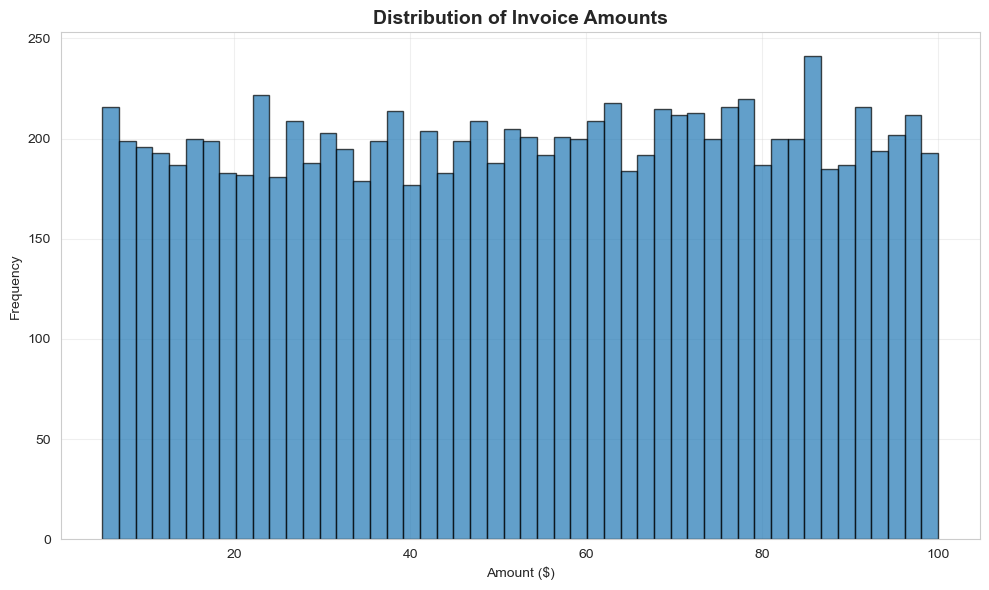


[1.4.2] Visualizing top cities by invoice count...


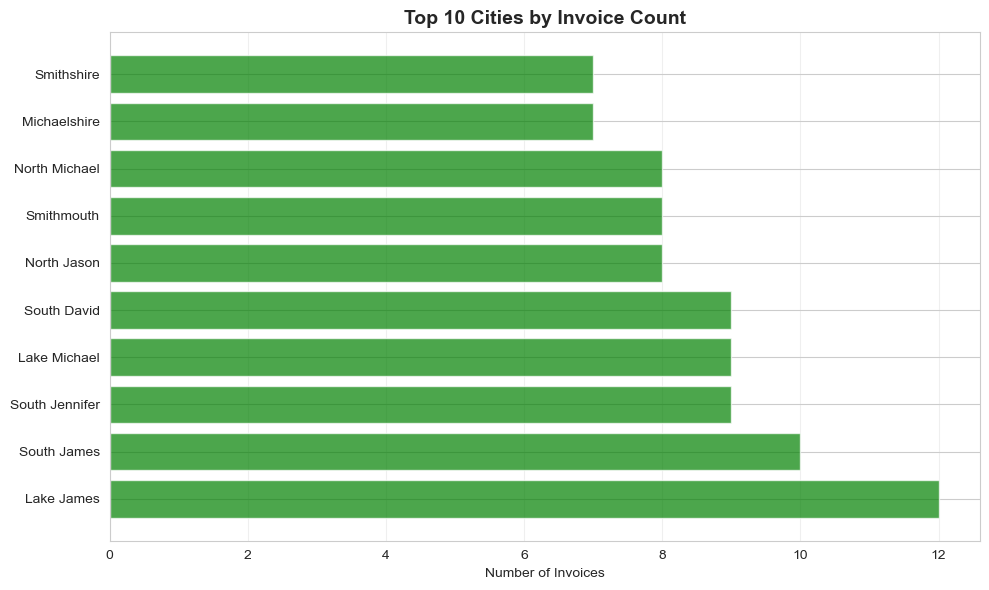


[1.4.3] Visualizing yearly revenue trends...


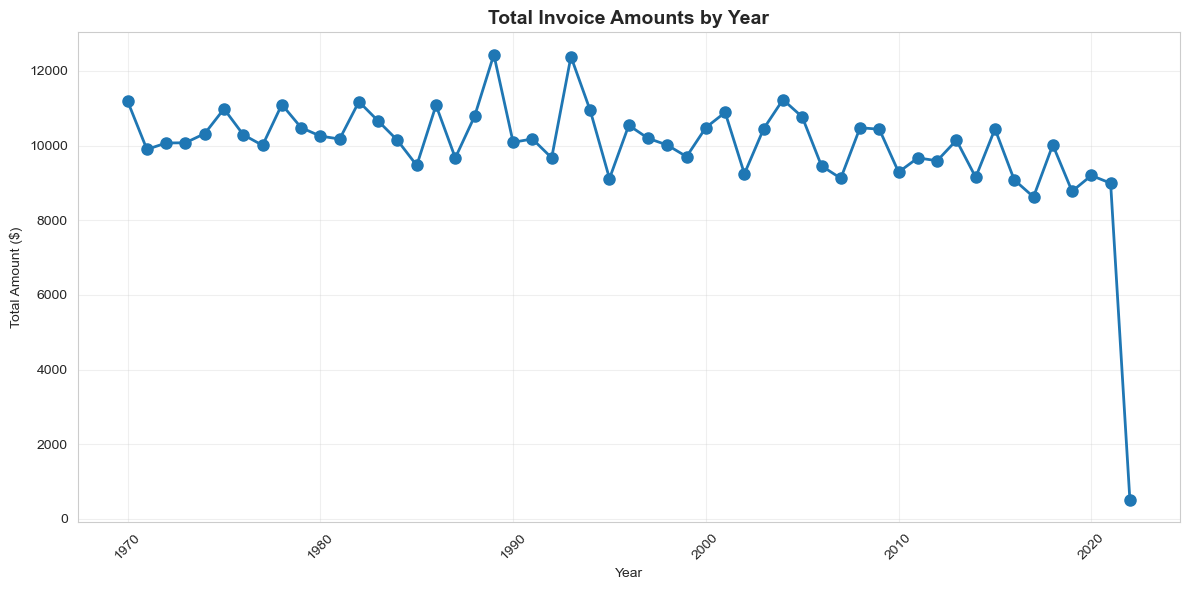


[Step 2] INFORMATION EXTRACTION USING ADVANCED TECHNIQUES

[Step 2.1] Applying Grouping Queries...

GROUPING QUERIES RESULTS

Total Revenue:
  $529,182.36

Maximal Number of Invoices by City:
  City: Lake James
  Maximum Invoice Count: 12


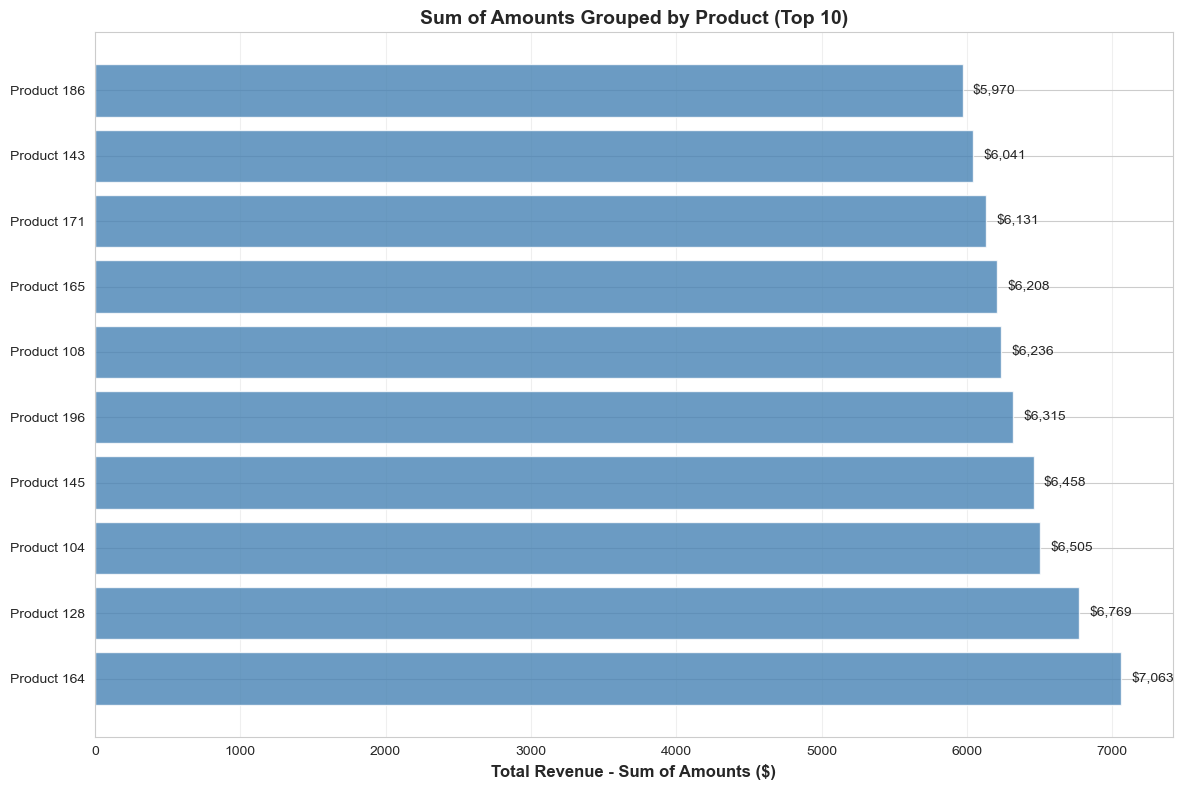


Top 5 Products by Sum of Amounts:
  Product 164.0: $7,063.05
  Product 128.0: $6,768.94
  Product 104.0: $6,505.23
  Product 145.0: $6,458.13
  Product 196.0: $6,314.91


[Step 2.2] Applying Data Transformation Methods...


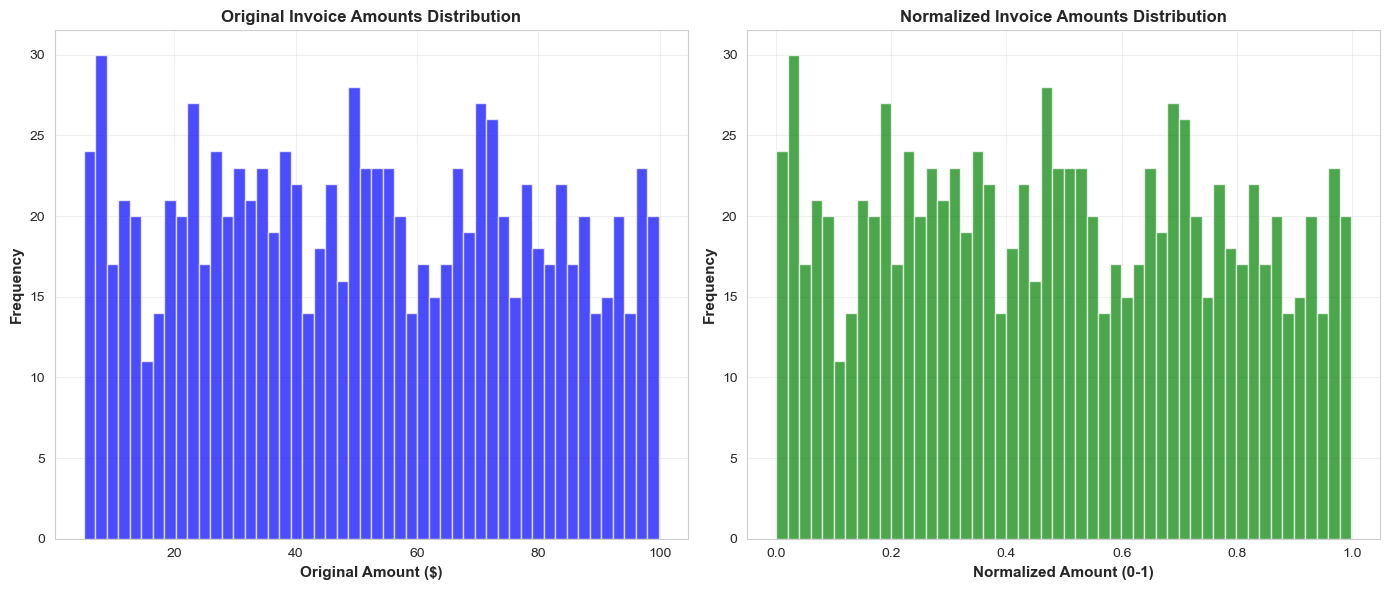

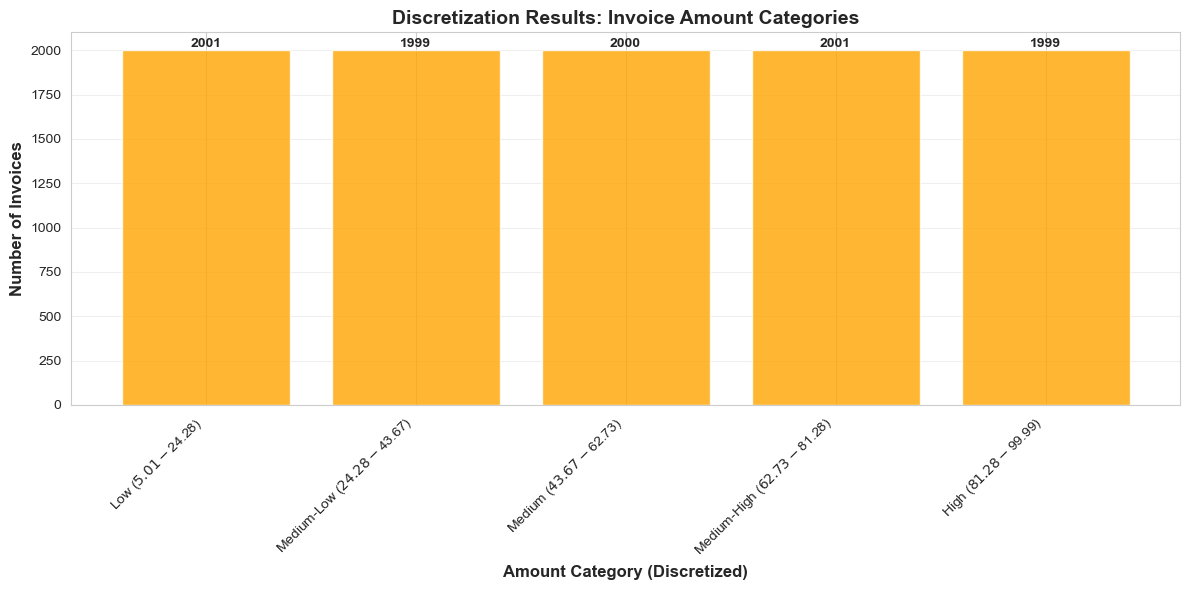


DATA TRANSFORMATION RESULTS SUMMARY

Normalization Statistics:
  Min normalized value: 0.0000
  Max normalized value: 1.0000
  Mean normalized value: 0.5044

Discretization Statistics:
  Low ($5.01-$24.28): 2,001 invoices (20.0%)
  Medium-Low ($24.28-$43.67): 1,999 invoices (20.0%)
  Medium ($43.67-$62.73): 2,000 invoices (20.0%)
  Medium-High ($62.73-$81.28): 2,001 invoices (20.0%)
  High ($81.28-$99.99): 1,999 invoices (20.0%)

No frequent patterns found above the minimum support threshold.


[Step 2.3] Performing Temporal Analysis with Forecasting...


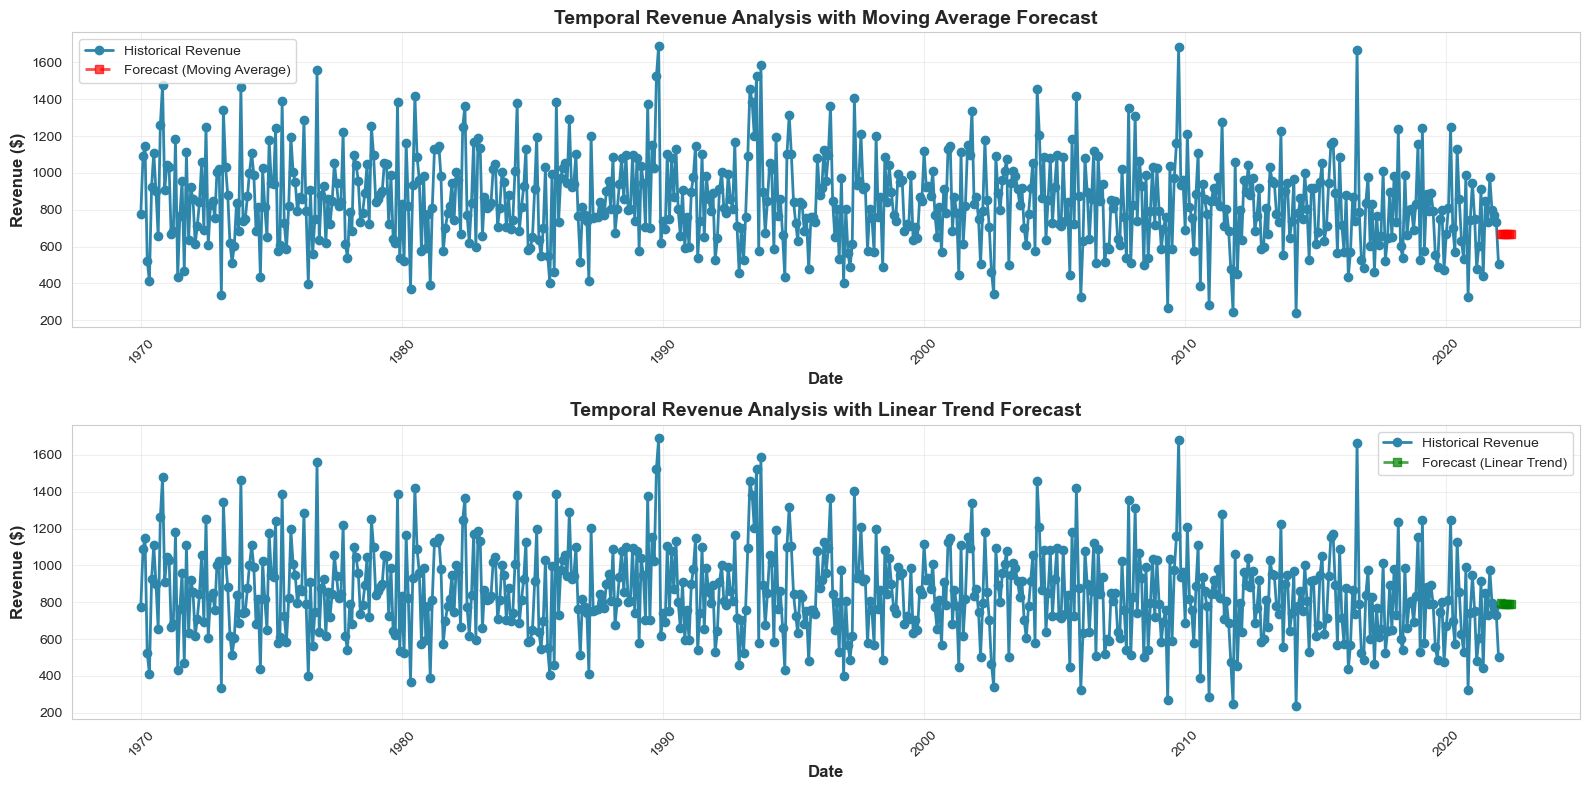


TEMPORAL ANALYSIS AND FORECASTING RESULTS

Historical Revenue Statistics:
  Total periods analyzed: 625
  Average monthly revenue: $846.69
  Total revenue: $529,182.36
  Revenue trend: Decreasing

Moving Average Forecast (next 6 periods):
  2022-02: $668.46
  2022-03: $668.46
  2022-04: $668.46
  2022-05: $668.46
  2022-06: $668.46
  2022-07: $668.46

Linear Trend Forecast (next 6 periods):
  2022-02: $792.94
  2022-03: $792.76
  2022-04: $792.59
  2022-05: $792.42
  2022-06: $792.25
  2022-07: $792.08


[Step 2.4] Performing Spatial Analysis with Clustering...


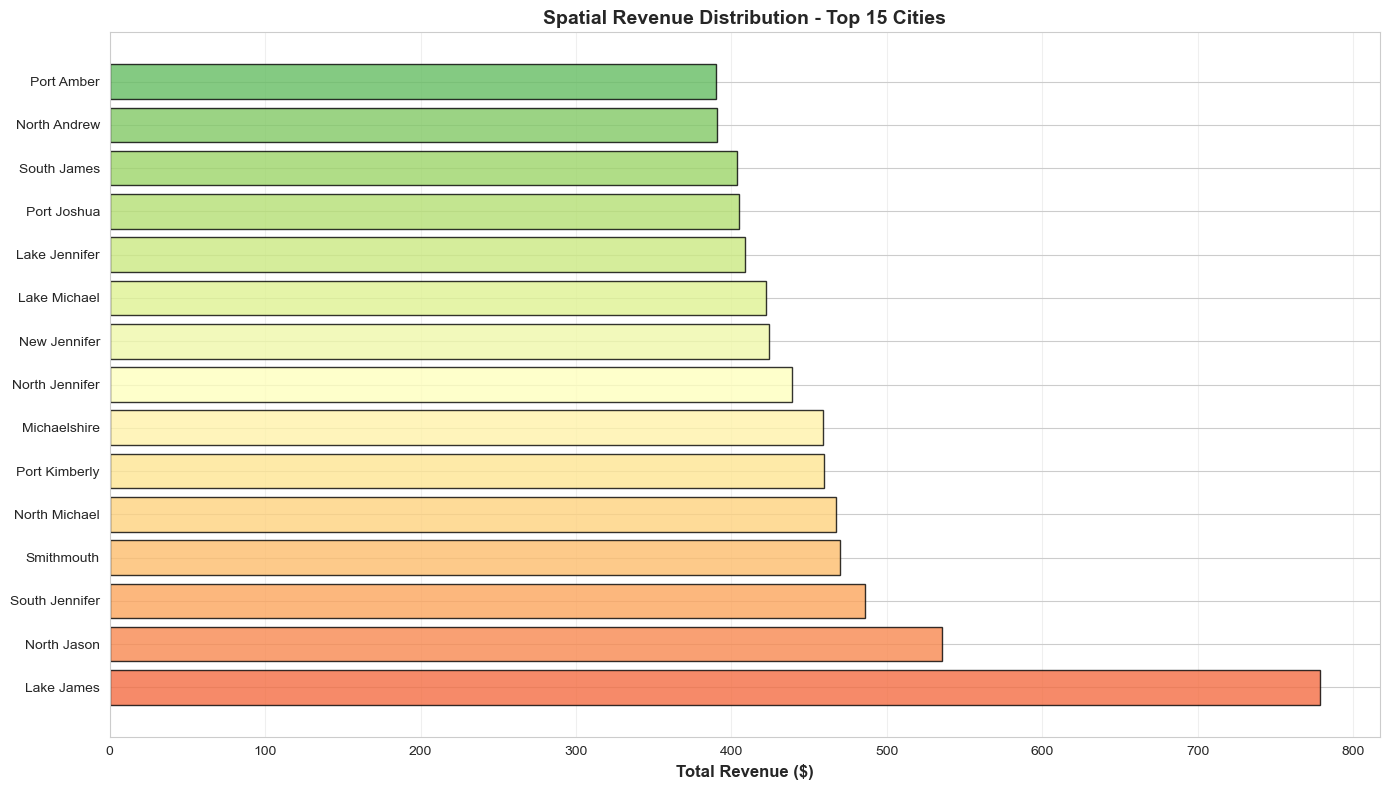

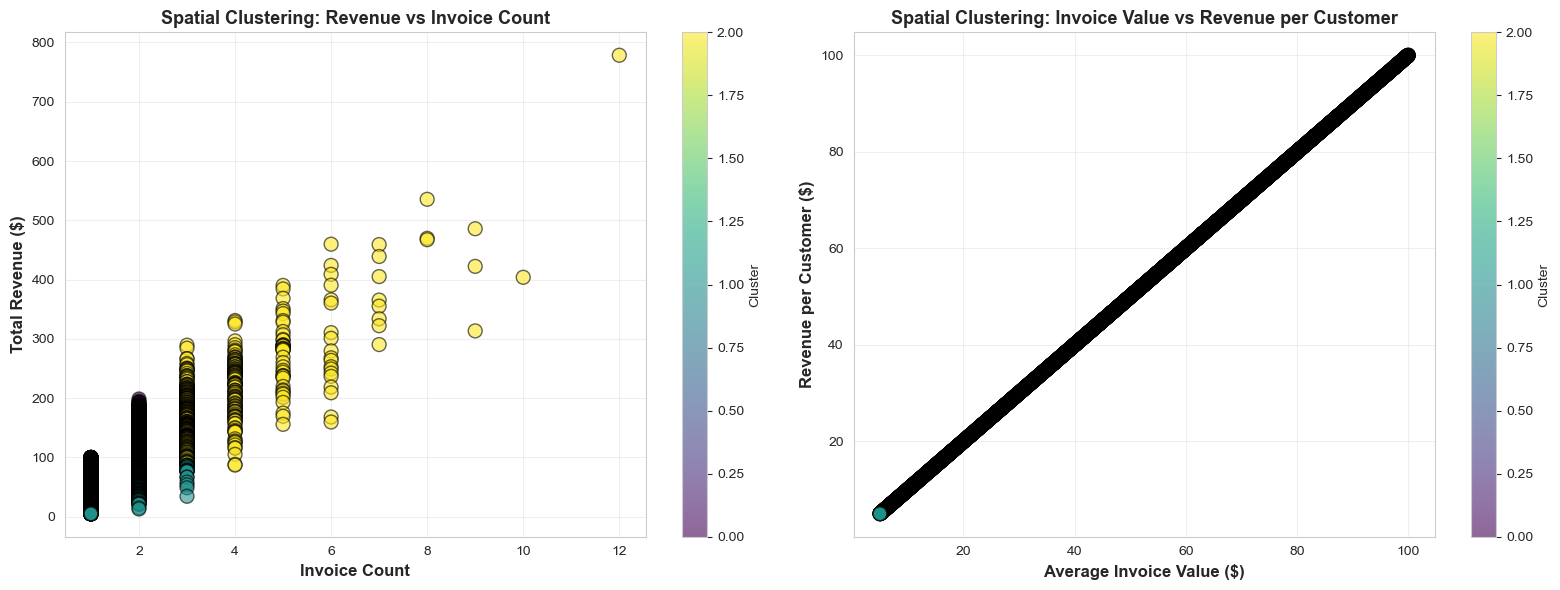

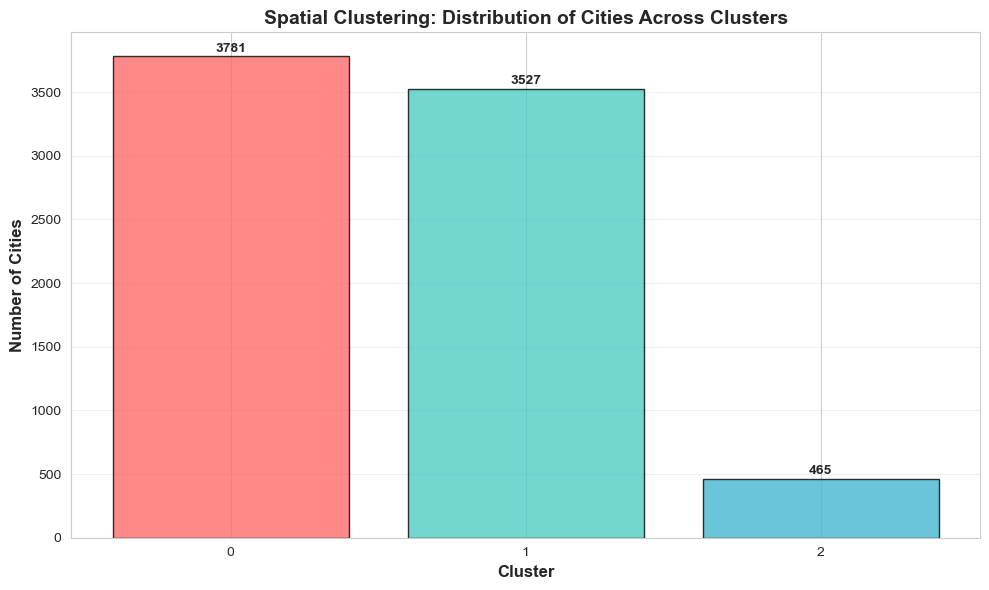


SPATIAL ANALYSIS AND CLUSTERING RESULTS

Spatial Revenue Distribution:
  Total cities analyzed: 7773
  Total revenue across all cities: $529,182.36
  Average revenue per city: $68.08

Top 5 Cities by Revenue:
  Lake James: $778.43 (12 invoices)
  North Jason: $535.47 (8 invoices)
  South Jennifer: $485.80 (9 invoices)
  Smithmouth: $469.65 (8 invoices)
  North Michael: $467.32 (8 invoices)

K-means Clustering Results (3 clusters):

  Cluster 0: 3781 cities
    Average Revenue: $84.89
    Average Invoice Count: 1
    Average Invoice Value: $74.66
    Sample cities: New Pamela, Port Ricky, West Cheryl

  Cluster 1: 3527 cities
    Average Revenue: $32.56
    Average Invoice Count: 1
    Average Invoice Value: $29.21
    Sample cities: Lake Steven, Penachester, Smithbury

  Cluster 2: 465 cities
    Average Revenue: $200.82
    Average Invoice Count: 4
    Average Invoice Value: $54.17
    Sample cities: Lake James, North Jason, South Jennifer



In [64]:
# Execute the main function to run the complete analysis
df, exploration_results = main()
